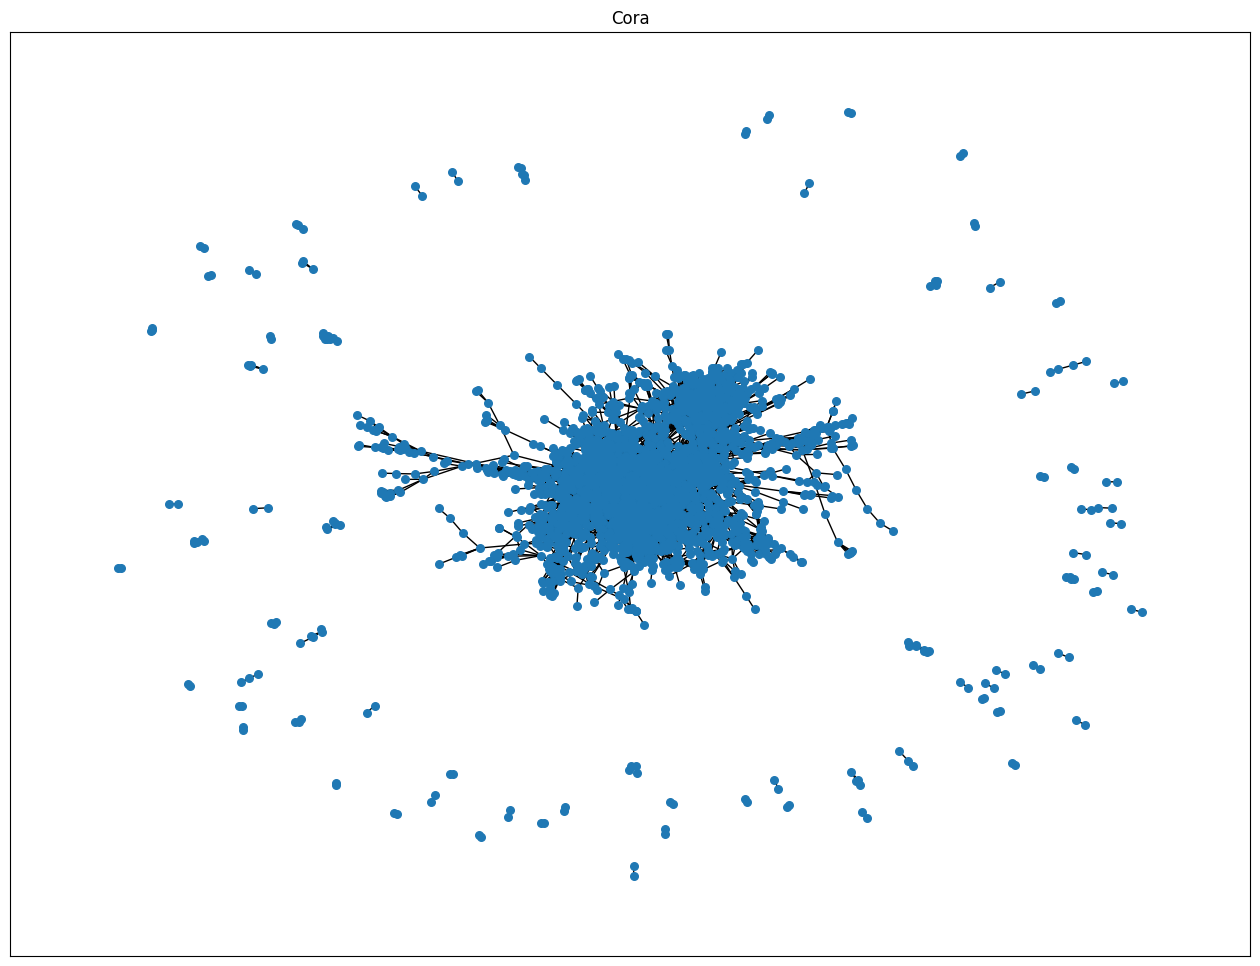

In [2]:
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch_geometric.nn import GATConv
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from GraphSVX_explainers import  GraphLIME

import matplotlib.pyplot as plt

%matplotlib inline

dataset = Planetoid('.', 'Cora', transform=NormalizeFeatures())
data = dataset[0]
data

plt.figure(figsize=(16, 12))

G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, k=0.1)
nx.draw_networkx(G, with_labels=False, node_size=30)

plt.title('Cora');

Node 1358 has the largest degree value 168.


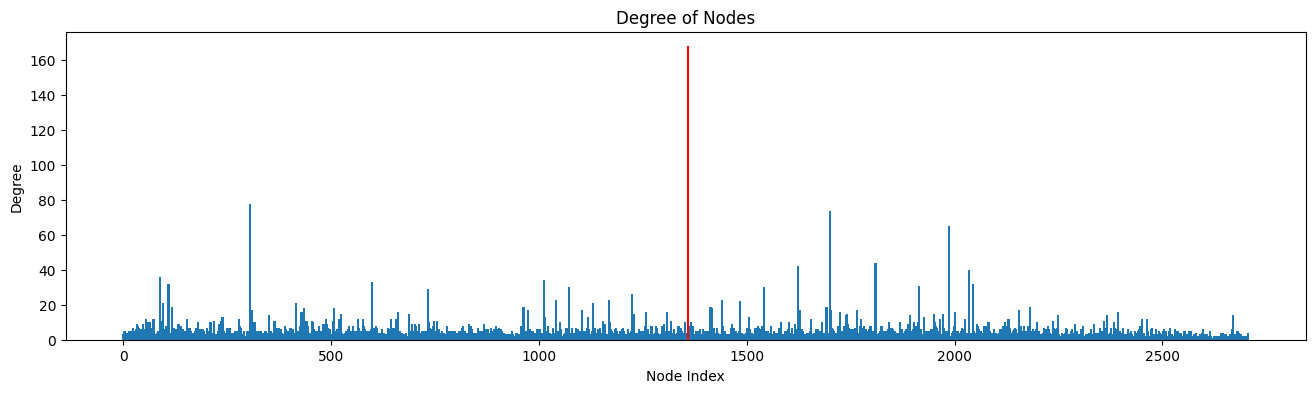

In [3]:
degrees = dict(nx.degree(G))
node_indices = list(degrees.keys())
node_degrees = list(degrees.values())

max_degree = max(node_degrees)
node_idx = np.argmax(node_degrees).item()

plt.figure(figsize=(16, 4))

plt.bar(node_indices, node_degrees, width=5.0)

plt.vlines(x=node_idx, ymin=0, ymax=max_degree, colors='r')

plt.title('Degree of Nodes')
plt.xlabel('Node Index')
plt.ylabel('Degree');

print(f'Node {node_idx} has the largest degree value {max_degree}.')

In [4]:
class GAT(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim,
                 heads_1=8, heads_2=1, att_dropout=0.6, input_dropout=0.6):
        
        super(GAT, self).__init__()

        self.att_dropout = att_dropout
        self.input_dropout = input_dropout

        self.conv1 = GATConv(in_channels=input_dim,
                             out_channels=hidden_dim // heads_1,
                             heads=heads_1,
                             concat=True,
                             dropout=att_dropout)
        self.conv2 = GATConv(in_channels=hidden_dim,
                             out_channels=output_dim,
                             heads=heads_2,
                             concat=False,
                             dropout=att_dropout)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.input_dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.input_dropout, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [5]:
hparams = {
    'input_dim': data.num_node_features,
    'hidden_dim': 16,
    'output_dim': max(data.y).item() + 1
}

model = GAT(**hparams)
model

GAT(
  (conv1): GATConv(1433, 2, heads=8)
  (conv2): GATConv(16, 7, heads=1)
)

In [6]:
def accuracy(output, labels):
    _, pred = output.max(dim=1)
    correct = pred.eq(labels).double()
    correct = correct.sum()
    
    return correct / len(labels)

lr = 0.005
epochs = 400

model.train()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    
    output = model(data.x, data.edge_index)
    loss = F.nll_loss(output[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        acc = accuracy(output[data.train_mask], data.y[data.train_mask])
        print('Epoch: {:3d}, acc = {:.3f}'.format(epoch, acc))

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:   0, acc = 0.157
Epoch:  10, acc = 0.407
Epoch:  20, acc = 0.564
Epoch:  30, acc = 0.657
Epoch:  40, acc = 0.650
Epoch:  50, acc = 0.671
Epoch:  60, acc = 0.686
Epoch:  70, acc = 0.621
Epoch:  80, acc = 0.714
Epoch:  90, acc = 0.686
Epoch: 100, acc = 0.707
Epoch: 110, acc = 0.686
Epoch: 120, acc = 0.707
Epoch: 130, acc = 0.657
Epoch: 140, acc = 0.750
Epoch: 150, acc = 0.714
Epoch: 160, acc = 0.743
Epoch: 170, acc = 0.750
Epoch: 180, acc = 0.700
Epoch: 190, acc = 0.750
Epoch: 200, acc = 0.757
Epoch: 210, acc = 0.779
Epoch: 220, acc = 0.800
Epoch: 230, acc = 0.779
Epoch: 240, acc = 0.750
Epoch: 250, acc = 0.771
Epoch: 260, acc = 0.800
Epoch: 270, acc = 0.771
Epoch: 280, acc = 0.757
Epoch: 290, acc = 0.779
Epoch: 300, acc = 0.871
Epoch: 310, acc = 0.786
Epoch: 320, acc = 0.721
Epoch: 330, acc = 0.764
Epoch: 340, acc = 0.800
Epoch: 350, acc = 0.786
Epoch: 360, acc = 0.807
Epoch: 370, acc = 0.779
Epoch: 380, acc = 0.807
Epoch: 390, acc = 0.786


1358

In [13]:
model.eval()
data.num_features=data.num_node_features

In [26]:
node_idx=31


In [27]:
# instantiate a GraphLIME object
explainer = GraphLIME(data, model, hop=2, rho=0.1, cached=True)

# explain node features by calling the method `explain_node()`
coefs = explainer.explain(node_idx, data.x, data.edge_index)

coefs

Kbar: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] and L_bar: [0. 0. 0. 0.]


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [19]:
sum(coefs)

0.11505652032792568

In [20]:
#print number of nodes
print(f'Number of nodes: {data.num_nodes}')
zero_nodes=[]
for n in range(data.num_nodes):
    coefs=explainer.explain(n,data.x,data.edge_index, printing=False)
    if sum(coefs)==0:
        zero_nodes.append(n)
print(f'Number of nodes with zero explanation: {len(zero_nodes)}')

Number of nodes: 2708


/home/agnes/desktop/tnevenv/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:771: RuntimeWarning: overflow encountered in divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny32))
/home/agnes/desktop/tnevenv/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:771: RuntimeWarning: overflow encountered in divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny32))
/home/agnes/desktop/tnevenv/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:771: RuntimeWarning: overflow encountered in divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny32))
/home/agnes/desktop/tnevenv/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:771: RuntimeWarning: overflow encountered in divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny32))
/home/agnes/desktop/tnevenv/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:771: RuntimeWarning: overflow encountered in divide
  

Number of nodes with zero explanation: 131


In [21]:
zero_nodes

[3,
 7,
 31,
 66,
 106,
 117,
 184,
 187,
 200,
 208,
 222,
 225,
 247,
 250,
 259,
 287,
 307,
 380,
 390,
 404,
 422,
 431,
 462,
 474,
 477,
 520,
 538,
 545,
 587,
 592,
 611,
 625,
 641,
 653,
 662,
 687,
 692,
 700,
 713,
 721,
 780,
 786,
 821,
 832,
 917,
 930,
 932,
 947,
 959,
 967,
 974,
 986,
 991,
 1005,
 1024,
 1032,
 1034,
 1044,
 1048,
 1059,
 1108,
 1170,
 1181,
 1208,
 1210,
 1231,
 1233,
 1236,
 1263,
 1286,
 1298,
 1310,
 1356,
 1371,
 1375,
 1393,
 1407,
 1438,
 1439,
 1476,
 1496,
 1541,
 1563,
 1594,
 1600,
 1613,
 1648,
 1673,
 1691,
 2255,
 2341,
 2410,
 2411,
 2429,
 2431,
 2432,
 2433,
 2461,
 2479,
 2529,
 2537,
 2544,
 2569,
 2583,
 2586,
 2600,
 2602,
 2603,
 2618,
 2619,
 2625,
 2626,
 2629,
 2631,
 2633,
 2639,
 2659,
 2660,
 2664,
 2665,
 2666,
 2669,
 2676,
 2690,
 2692,
 2694,
 2695,
 2697,
 2703,
 2704,
 2705]

In [28]:
len(zero_nodes)

131